# 1. Introduction


Sequences of discrete tokens can be found in many applications, namely words in a text, notes in a musical composition, pixels in an image, actions in a reinforcement learning agent, etc [[1]](https://arxiv.org/pdf/1801.00632.pdf). These sequences often show a strong correlation between consecutive or nearby tokens. The correlations on words in a sentence or characters in words express the underlying semantics and language characteristics.
The next token in the sequence $x_n$ can be modeled as

$$p(x_n|x_{n-1}, x_{n-2},...,x_1)$$

where $x_i$ represents the $i^{th}$ token in the sequence. In Natural Language Processing (NLP) they are defined as language models and usually, each token stands for a separate word or $n$-gram. The output generated is a probability distribution from which we can sample to generate the next token in the sequence. These models are also known as recurrent, as we can apply this generative process recurrently to create entire new sequences of tokens.

One particular type of generative model often used to tackle problems with sequences of discrete tokens is Recurrent Neural Networks (RNN). In a simpler neural network, a fixed-dimensional feature representation is transformed several times by different non-linear functions. In an RNN, these transformations are also repeated in time, which means that at every time step a new input is processed that generates a new output. They can effectively capture semantically rich representations of the input sequences [[2]](https://icml.cc/Conferences/2011/papers/524_icmlpaper.pdf). RNN showed this capacity in different settings, such as generating structured text, original images (on a per pixels basis) or even modeling user behavior on online services.

Our task is to generate original text that resemble a training corpus. It is an unsupervised task, as we do not have access to any labeling or target variable. We start by creating a word embedding that maps each character to a vector with a parameterized dimension. For each character the model looks up the embedding and feeds the result to a stack of Long Short-Term Memory (LSTM) layers, a specific type of RNN. These were developed to extend the traditional RNNs capacity to model long-term dependencies and counter the vanishing gradient problem. The output of our network is a dense layer with a number of units equal to the vocabulary size. We did not define an activation function for this layer; it simply outputs one logit for each character in the vocabulary. We use these values to later sample from a categorical distribution.

In this article, we use the work of Fernando Pessoa, one of the most significant literary figures of the 20th century and one of the greatest poets in the Portuguese language. This dataset is now publicly available on Kaggle and consists of more than 4300 poems, essays and other writings [[3]](https://www.kaggle.com/luisroque/the-complete-literary-works-of-fernando-pessoa).

# 2. Data Preprocessing

The dataset comprises several texts written by the author under different names, heteronyms, and pseudonyms. Each one has his own style of writing, which could be interesting to learn separately and compare. Nevertheless, to efficiently train Deep Neural Networks (DNN) we need a large dataset. F. Pessoa lived part of his youth in South Africa, where he was exposed to the English language. That is why part of his work is written in English. To avoid introducing noise, we remove most of the English texts from the training dataset.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import ast
import os
import json
import matplotlib.pyplot as plt
from nltk import tokenize
import seaborn as sns

Length of texts dataset: 5811145 characters


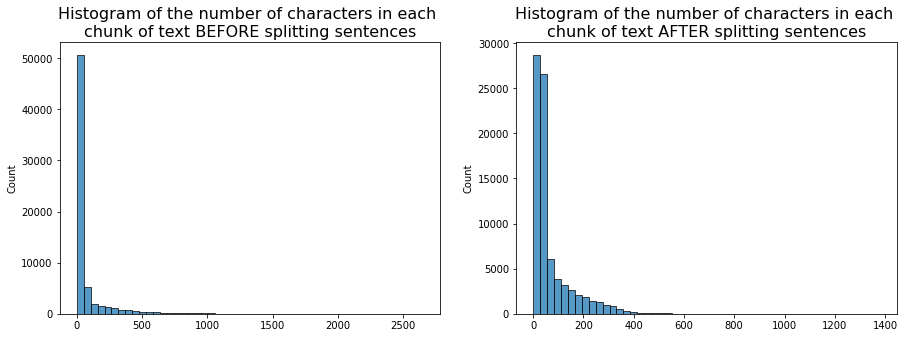

In [2]:
f_pessoa = pd.read_csv('/kaggle/input/the-complete-literary-works-of-fernando-pessoa/f_pessoa_v2.csv')

texts = f_pessoa.copy()

# Removing all pseudonyms that wrote in english.

texts = texts[~texts['author'].isin(['Alexander Search', 'David Merrick', 'Charles Robert Anon', 'I. I. Crosse'])]

texts['text'] = texts['text'].apply(lambda t: ast.literal_eval(t))
texts = texts.reset_index().drop('index', axis=1)
texts = texts['text'].tolist()
texts = np.concatenate(texts)

texts = np.asarray(texts)
texts_p = " ".join(texts)

# we will be truncating large texts soon, so this code only tries to reduce the 
# sequence size by spliting the texts that seem to be significantely larger than 
# the rest. Otherwise, we try to use the structure provided in the data itself

_, ax = plt.subplots(1, 2, figsize=(15, 5))

mylen = np.vectorize(len)

sns.histplot(mylen(texts), bins=50, ax=ax[0])
ax[0].set_title('Histogram of the number of characters in each \nchunk of text BEFORE splitting sentences', fontsize=16)

large_texts = texts[mylen(texts)>350]
large_texts_p = " ".join(large_texts)
large_texts = tokenize.sent_tokenize(large_texts_p)

texts = np.concatenate((texts[~(mylen(texts)>350)], large_texts))

ax[1].set_title('Histogram of the number of characters in each \nchunk of text AFTER splitting sentences', fontsize=16)
sns.histplot(mylen(texts), bins=50, ax=ax[1]);

print(f'Length of texts dataset: {len(texts_p)} characters')

After cleaning up the texts, we end up with more than 5.8M of characters. Notice that in order to avoid losing data when normalizing the text length of our sequences, we split the largest sequences by sentence. The difference in the distribution of the sequence length can be seen in the histograms above. We can preview some of the sequences.

In [3]:
print(texts[97:106])

['O burburinho da água' 'O burburinho da água' 'No regato que se espalha'
 'É como a ilusão que é mágoa' 'Quando a verdade a baralha.'
 '— A única vantagem de estudar é gozar o quanto os outros não disseram.'
 '— A arte é um isolamento. Todo o artista deve buscar isolar os outros, levar-lhes às almas o desejo de estarem sós. O triunfo supremo de um artista é quando a ler suas obras o leitor prefere tê-las e não as ler. Não é porque isto aconteça aos consagrados; é porque é o maior tributo (...)'
 '— Ser lúcido é estar indisposto consigo próprio. O legítimo estado de espírito com respeito a olhar para dentro de si próprio é o estado (...) de quem olha nervos e indecisões.'
 'A única atitude intelectual digna de uma criatura superior é a de uma calma e fria compaixão por tudo quanto não é ele próprio. Não que essa atitude tenha o mínimo cunho de justa e verdadeira; mas é tão invejável que é preciso tê-la.']


More importantly, we can assess the number of unique characters, which is our vocabulary size.

In [4]:
vocab = sorted(set(texts_p))
print(f'{len(vocab)} unique characters in texts')

156 unique characters in texts


Before training, we need to convert the strings to some numerical representation. We started by tokenizing the text with some important aspects in mind. We considered an unlimited number of tokens and created them at the character level. We did not filter any character and kept the original capitalization. We then use the tokenizer to map our texts to encoded sequences.

In [5]:
def create_character_tokenizer(list_of_strings):
    tokenizer = Tokenizer(filters=None,
                         char_level=True, 
                          split=None,
                         lower=False)
    tokenizer.fit_on_texts(list_of_strings)
    return tokenizer

tokenizer = create_character_tokenizer(texts)

tokenizer_config = tokenizer.get_config()

word_counts = json.loads(tokenizer_config['word_counts'])
index_word = json.loads(tokenizer_config['index_word'])
word_index = json.loads(tokenizer_config['word_index'])

def strings_to_sequences(tokenizer, list_of_strings):
    sentence_seq = tokenizer.texts_to_sequences(list_of_strings)
    return sentence_seq

seq_texts = strings_to_sequences(tokenizer, texts)

We can see an example of this encoding.

In [6]:
print('Original sequence: \n' + texts[0] + '\n')
print('Encoded sequence: ')
print(seq_texts[0])

Original sequence: 
Diana através dos ramos

Encoded sequence: 
[46, 6, 3, 8, 3, 1, 3, 9, 7, 3, 19, 26, 5, 1, 10, 4, 5, 1, 7, 3, 11, 4, 5]


We also need to normalize the length of our sequences, for which we define a length of 300 characters. Sequences smaller than 300 are padded with zeros, while sequences bigger than 300 are truncated.

In [7]:
mylen = np.vectorize(len)

print(max(mylen(texts)))
print(np.round(np.mean(mylen(texts))))

1377
71.0


In [8]:
def make_padded_dataset(sequences):
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequences,
                                                 maxlen=300,
                                                 padding='pre',
                                                 truncating='pre',
                                                 value=0)
    return padded_sequence

padded_sequences = make_padded_dataset(seq_texts)

The RNN works by receiving a sequence of characters and predicting the next character in the sequence. At training time, the model receives an input sequence and a target sequence, which is shifted by one.

For example, the expression `Diana através dos ramos` is the first verse of the first poem on our dataset. The poem is from Ricardo Reis, one of the many heteronyms of F.Pessoa. Given the input `Diana através dos ramo`, the correct prediction is `iana através dos ramos`. Notice that the prediction is the same length as the input.

Another decision we took was to build our RNN to be stateful, which means that its internal state is maintained across batches. For this to be effective, we need to make sure that each batch element follows on from the corresponding element of the preceding batch.

In [9]:
def create_inputs_and_targets(array_of_sequences, batch_size=32):
    input_seq = array_of_sequences[:,:-1]
    target_seq = array_of_sequences[:,1:]
    
    # Prepare the batches and ensure that is ready to be fed to a stateful RNN
    
    num_examples = input_seq.shape[0]

    num_processed_examples = num_examples - (num_examples % batch_size)

    input_seq = input_seq[:num_processed_examples]
    target_seq = target_seq[:num_processed_examples]

    steps = int(num_processed_examples / 32) 

    inx = np.empty((0,), dtype=np.int32)
    for i in range(steps):
        inx = np.concatenate((inx, i + np.arange(0, num_processed_examples, steps)))

    input_seq_stateful = input_seq[inx]
    target_seq_stateful = target_seq[inx]
    
    # Split data between training and validation sets
    
    num_train_examples = int(batch_size * ((0.8 * num_processed_examples) // batch_size))

    input_train = input_seq_stateful[:num_train_examples]
    target_train = target_seq_stateful[:num_train_examples]

    input_valid = input_seq_stateful[num_train_examples:]
    target_valid = target_seq_stateful[num_train_examples:]
    
    # Create datasets objects for training and validation data
    
    dataset_train = tf.data.Dataset.from_tensor_slices((input_train, target_train))
    dataset_train = dataset_train.batch(batch_size, drop_remainder=True)

    dataset_valid = tf.data.Dataset.from_tensor_slices((input_valid, target_valid))
    dataset_valid = dataset_valid.batch(batch_size, drop_remainder=True)
    
    return (dataset_train, dataset_valid)
    

train_data, valid_data = create_inputs_and_targets(padded_sequences)

# 3. Recurrent Neural Network

We started by defining an embedding layer that turns our indexes of characters into dense vectors of fixed size. It is important to note that padded values are masked in this layer, which means they are ignored. Next, we stacked 2 unidirectional stateful LSTM layers, each with 512 units. These layers have the potential to learn long-term dependencies; however, they are computationally expensive to train. In between them, we introduced a dropout layer. Finally, the last layer outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model. Notice that we get a total of about 4M parameters to train.

In [10]:
def get_model(vocab_size, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim = 256, mask_zero=True, batch_input_shape=(batch_size, None)),
        tf.keras.layers.LSTM(units=512, return_sequences=True,stateful=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=512, return_sequences=True,stateful=True),
        tf.keras.layers.Dense(units=vocab_size)
    ])
    return model

In [11]:
batch_size=32
model = get_model(len(tokenizer.word_index) + 1, batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (32, None, 256)           40192     
_________________________________________________________________
lstm (LSTM)                  (32, None, 512)           1574912   
_________________________________________________________________
dropout (Dropout)            (32, None, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (32, None, 512)           2099200   
_________________________________________________________________
dense (Dense)                (32, None, 157)           80541     
Total params: 3,794,845
Trainable params: 3,794,845
Non-trainable params: 0
_________________________________________________________________


In [12]:
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./models/ckpt',
                                                       save_weights_only=True,
                                                       save_best_only=True)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])
history = model.fit(train_data, 
                    epochs=30, 
                    validation_data=valid_data,
                    callbacks=[checkpoint_callback, tf.keras.callbacks.EarlyStopping(patience=2)])

Epoch 1/30
2023/2023 [==============================] - 1041s 512ms/step - loss: 0.5216 - sparse_categorical_accuracy: 0.3516 - val_loss: 0.3298 - val_sparse_categorical_accuracy: 0.5669
Epoch 2/30
2023/2023 [==============================] - 1031s 509ms/step - loss: 0.3195 - sparse_categorical_accuracy: 0.5704 - val_loss: 0.3025 - val_sparse_categorical_accuracy: 0.5946
Epoch 3/30
2023/2023 [==============================] - 1034s 511ms/step - loss: 0.2957 - sparse_categorical_accuracy: 0.5958 - val_loss: 0.2925 - val_sparse_categorical_accuracy: 0.6050
Epoch 4/30
2023/2023 [==============================] - 1029s 509ms/step - loss: 0.2842 - sparse_categorical_accuracy: 0.6085 - val_loss: 0.2869 - val_sparse_categorical_accuracy: 0.6109
Epoch 5/30
2023/2023 [==============================] - 1032s 510ms/step - loss: 0.2769 - sparse_categorical_accuracy: 0.6165 - val_loss: 0.2835 - val_sparse_categorical_accuracy: 0.6149
Epoch 6/30
2023/2023 [==============================] - 1033s 511

In [13]:
def model_history(history):
    history_dict = dict()
    for k, v in history.history.items():
        history_dict[k] = [float(val) for val in history.history[k]]
    return history_dict


history_dict = model_history(history)

# 4. Results

The training is quite slow even using GPU (despite reducing the training time for a factor of 15 compared to CPU) and recall that we only stacked two LSTM layers with a limited number of units. From the figure below, we can see a rapid increase of the accuracy on both the training and validation datasets and then a steady climb for several epochs. Our callback is eventually executed (when there is no increase in the validation accuracy for more than 2 epochs) to stop the training process. There was no sign of overfitting.

The resulting original text is quite interesting to analyze. Remember that our RNN had to learn the Portuguese language from scratch with a fairly small dataset. No explicit information such as the syntax or semantics is at any time provided to the model other than practical examples on writings in Portuguese. The dataset is also fairly small for the task. Nevertheless, there are interesting learnings to take notice of. For example, in terms of punctuation, the quotation marks are used correctly, showing the understanding that they are required to open and close. In sentences such as _Desassossego não poderia!… Falências no meu coração…_ or _As canções… é um sono de ouvir… Ficção tanto!…_ we can almost grasp some of the rentlessness of Fernando Pessoa. On the other hand, we see that the meaning or intention is not something that an RNN can capture and we can also identify some orthographic errors.

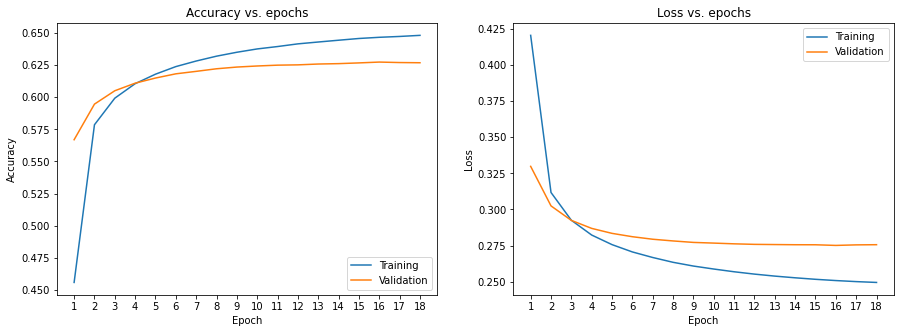

In [14]:
def plot_history(history_dict):
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history_dict['sparse_categorical_accuracy'])
    plt.plot(history_dict['val_sparse_categorical_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
    ax = plt.gca()
    ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
    plt.legend(['Training', 'Validation'], loc='lower right')

    plt.subplot(122)
    plt.plot(history_dict['loss'])
    plt.plot(history_dict['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(len(history_dict['sparse_categorical_accuracy'])))
    ax = plt.gca()
    ax.set_xticklabels(1 + np.arange(len(history_dict['sparse_categorical_accuracy'])))
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 
    
plot_history(history_dict)

In [17]:
model = get_model(len(tokenizer.word_index) + 1, batch_size=1)
model.load_weights(tf.train.latest_checkpoint('./models/')).expect_partial()

def get_logits(model, token_sequence, initial_state1=None, initial_state2=None):
    token_sequence = np.asarray(token_sequence)
    if initial_state1 is not None:
        # set states for all recurrent layers
        model.layers[1].states = initial_state1
        model.layers[3].states = initial_state2
    else:
        model.layers[1].reset_states()
        model.layers[3].reset_states()
    logit = model.predict(token_sequence)
    logit = logit[:,-1,:]
    
    return logit

def sample_token(logits):
    pred = tf.random.categorical(logits, num_samples=1).numpy()[0]
    return pred[0]

To generate text from our model, we need to specify a seed string to get the network started. Next, we tokenize the initial string and reset the state of the network. The string is then converted to a tensor with a batch size of 1 to fed to our model. We used the prediction from the last time step to build a categorical distribution and sample from it afterward. Using the same state of our network and the previously sampled token, we can repeat the prediction step until we get the final sequence with the specified size.

In [31]:
init_string = 'Desassossego'
num_generation_steps = 500

token_sequence = tokenizer.texts_to_sequences([init_string])
initial_state_1, initial_state_2 = None, None
input_sequence = token_sequence

for _ in range(num_generation_steps):
    logits = get_logits(model, 
                        input_sequence, 
                        initial_state1=initial_state_1,
                        initial_state2=initial_state_2)
    sampled_token = sample_token(logits)
    token_sequence[0].append(sampled_token)
    input_sequence = [[sampled_token]]
    initial_state_1 = model.layers[1].states
    initial_state_2 = model.layers[3].states
    
print(tokenizer.sequences_to_texts(token_sequence)[0][::2])

Desassossego não poderia!... Falências no meu coração... Esse reer sobre os braços dos meus caminhos e ignorantes possamos «exensação simbólica» e em Natureza, e a noite nova da ausência de cada? Não pense de bem entendida uma orientada prosa). V. como fui... As canções... é um sono de ouvir... Ficção tanto!... Vejo outro olhar pela Tristeza da cadeira, rainha para a Carta, a noite. Depois no paganismo que se sente no espaço real e de criar uma pedra de tradição sociológica para implicar o de Aristoclator S


# 5. Conclusion

For this task, the preprocessing of the data is challenging. We need to ensure that we have our input sequence encoded in a way that is suitable for the RNN to effectively capture the available semantic representation. RNNs are particularly computationally expensive to train, so we decided to keep the structure as simple as possible. The results are interesting as we were able to generate text in Portuguese without proving any structural information about the language to the model other than the writings of a poet. The model learned some of the fundamental structure of the language while preserving some nuances that we can consider similar to the training corpus.
This approach can be extended by increasing the depth of the model with more recurrent layers and the number of units in each layer. Hyperparameters such as the batch size can also be tuned to increase accuracy. We tested the possibility to separate by the form of writing, training one DNN with texts in prose and another with texts in poetry. The results were not satisfying, as the DNNs failed to generate text with a coherent structure. We leave it as future work.

# 6. References

[[1]](https://arxiv.org/pdf/1801.00632.pdf) - [De Boom et al., 2018] De Boom, C., Demeester, T., and Dhoedt, B. (2018). Character-level recur-rent neural networks in practice: comparing training and sampling schemes.Neural Computing and Applications, 31(8):4001–4017.

[[2]](https://icml.cc/Conferences/2011/papers/524_icmlpaper.pdf) - [Sutskever et al., 2011] Sutskever, I., Martens, J., and Hinton, G. (2011). Generating text with recurrent neural networks. ICML’11, page 1017–1024, Madison, WI, USA. Omnipress.

[[3]](https://www.kaggle.com/luisroque/the-complete-literary-works-of-fernando-pessoa) - https://www.kaggle.com/luisroque/the-complete-literary-works-of-fernando-pessoa